This project concerns the Collatz conjecture - that each positive integer will eventually lead to 1 of a particular function is iteratively applied to it. The function is: if the input is even, halve; if odd, triple and add one. See the Appendix A for a worked example.

This project will

- programmatically generate the required data for analysis,
- use data visualization techniques to assist exploratory data analysis,
- apply various machine learning techniques to the generated data,
- calculate and report the accuracies of the applied models,
- interpret the accuracies visually alongside the original data, and
- draw conclusions relevant to the process of data investigation generally.


In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# a function which accepts a positive integer n, and returns its Collatz length

def length(n):
    if n==0: return(-1)
    count = 0
    while n!=1:
        if n%2==0:
            n=n/2
            count+=1
        else:
            n=3*n+1
            count+=1
    return(count)

In [3]:
# the length of the data set to generate. It will find the Collatz length of the first max_num positive integers.

max_num = 10001

ls = []
for i in range(0,max_num):
    ls.append({'n':i,'length':length(i)})

df = pd.DataFrame(ls)

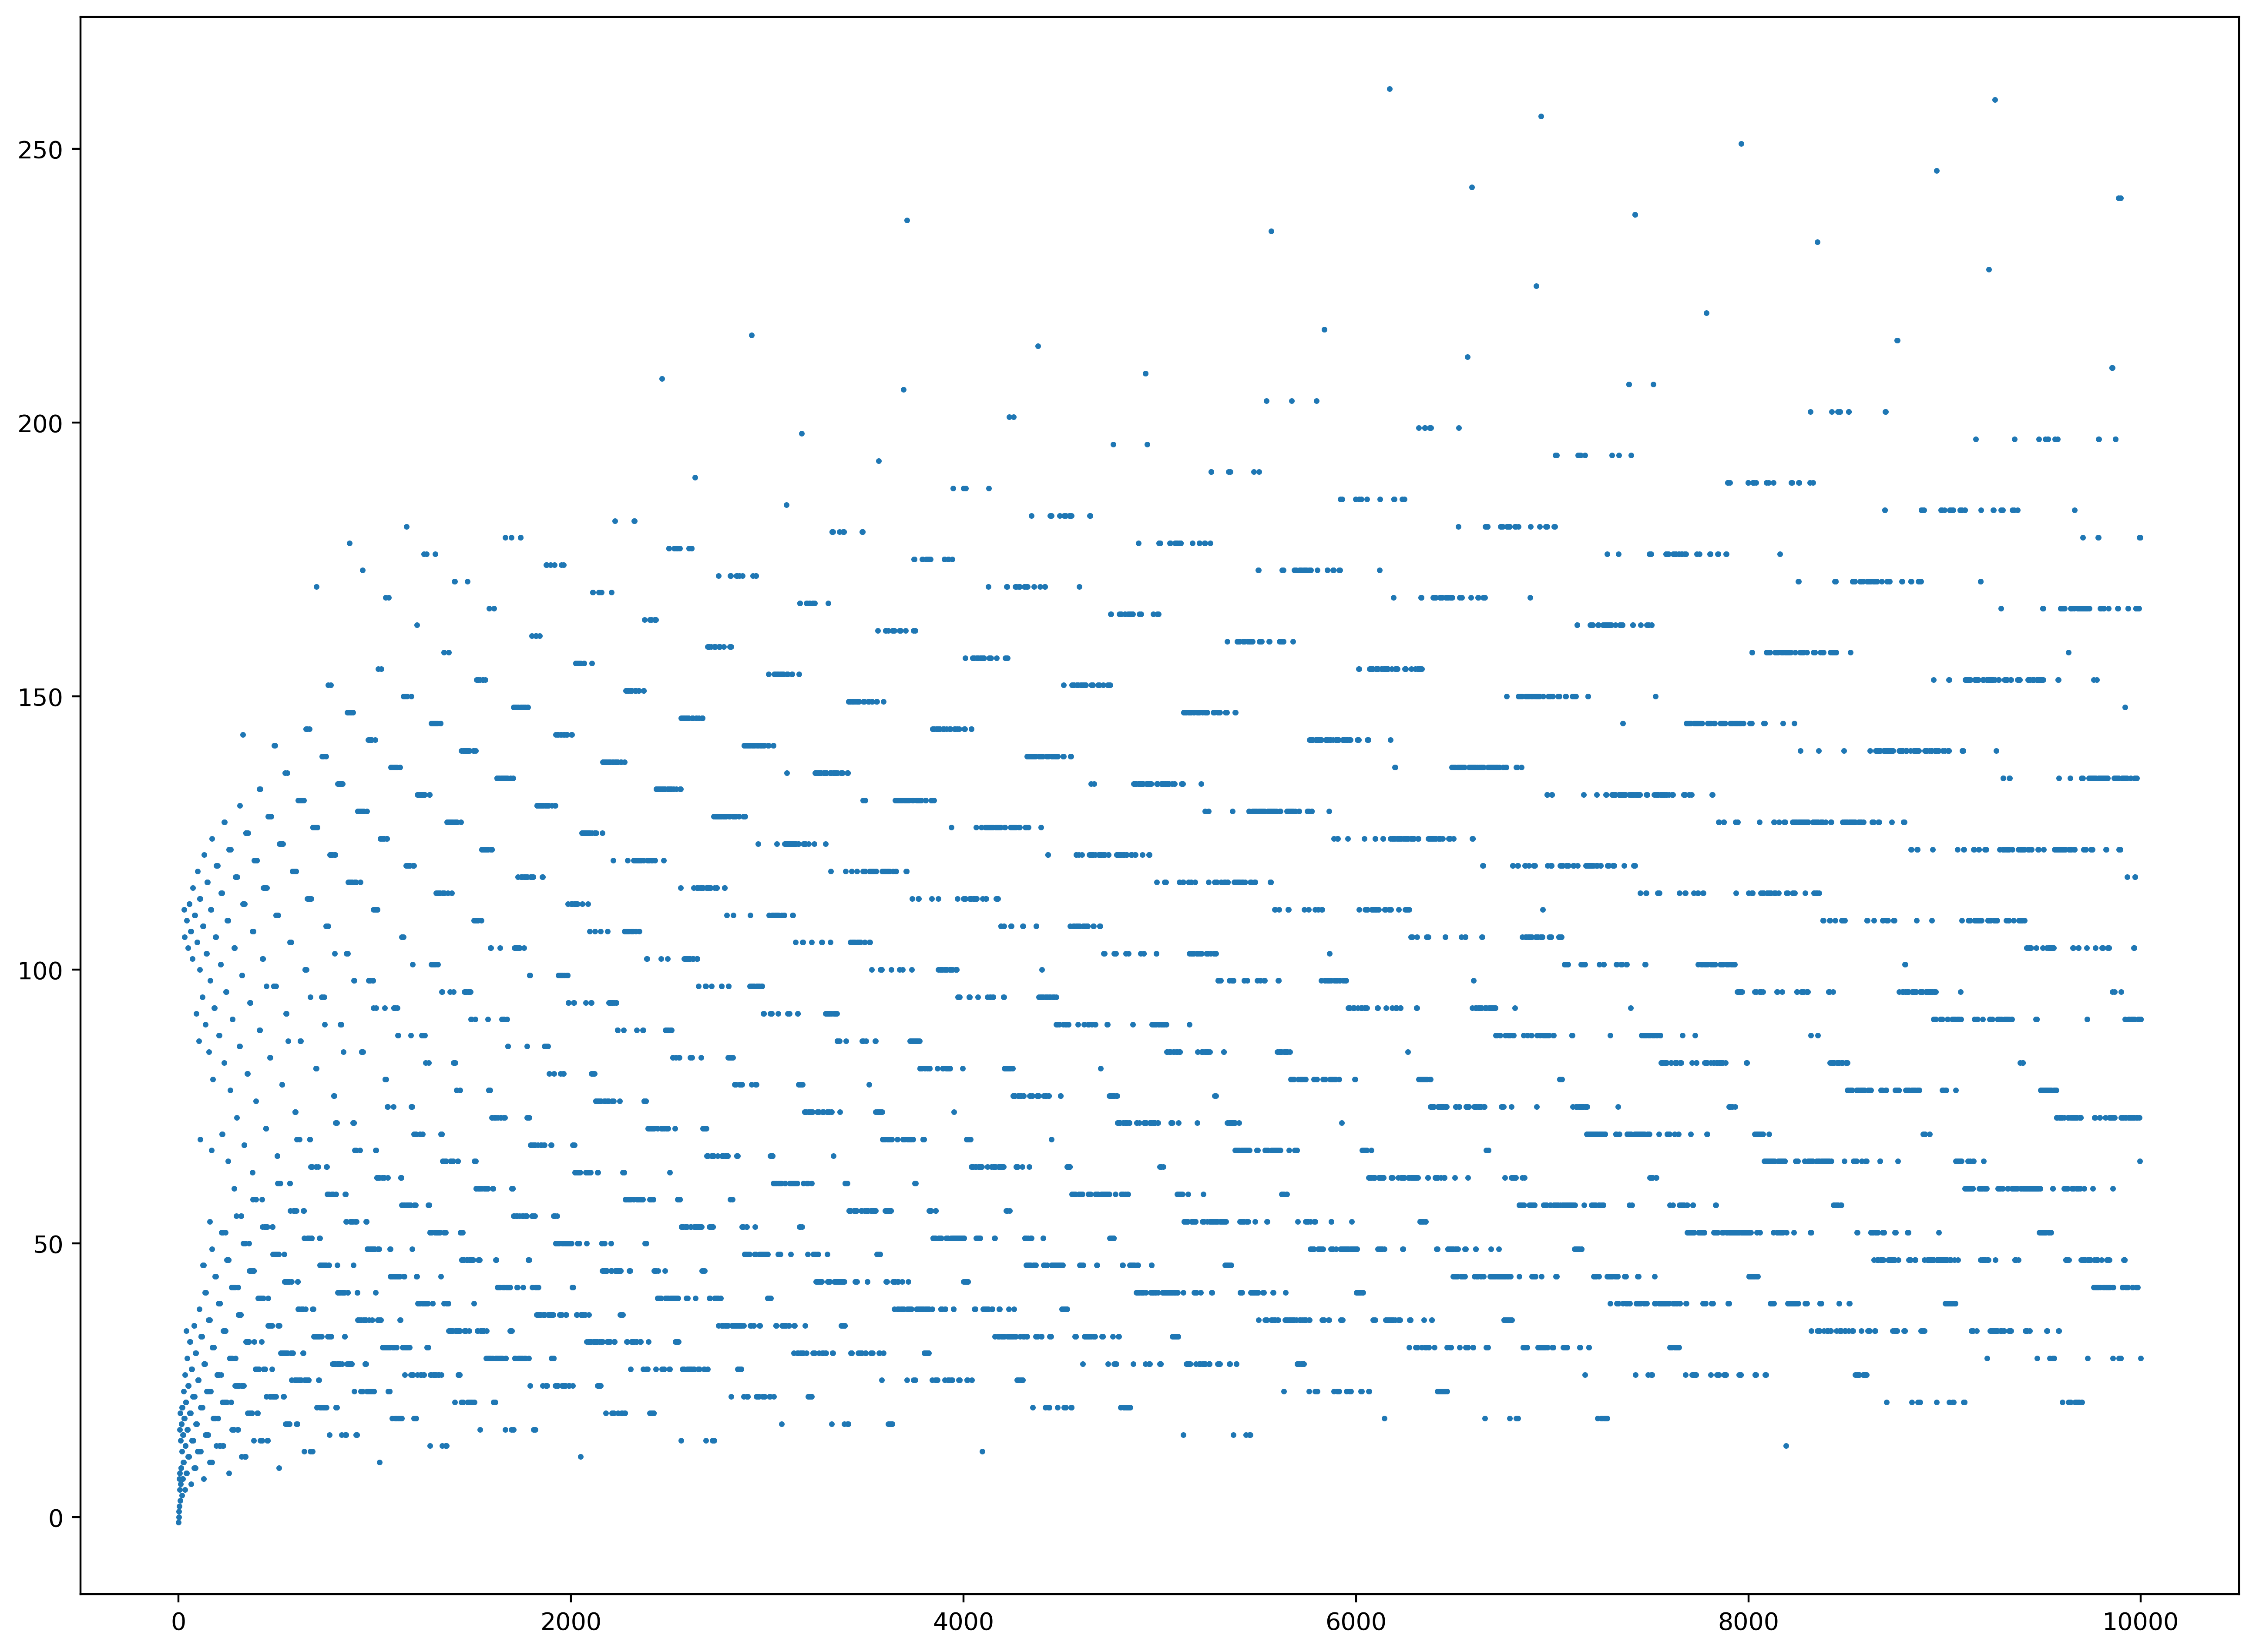

In [4]:
# visualizing the distribution of the Collatz lengths of the first 10000 positive integers

plt.figure(figsize=(16, 12), dpi=400)
plt.scatter(df.n, df.length, s = 1.8)
plt.show()

<IPython.core.display.Javascript object>


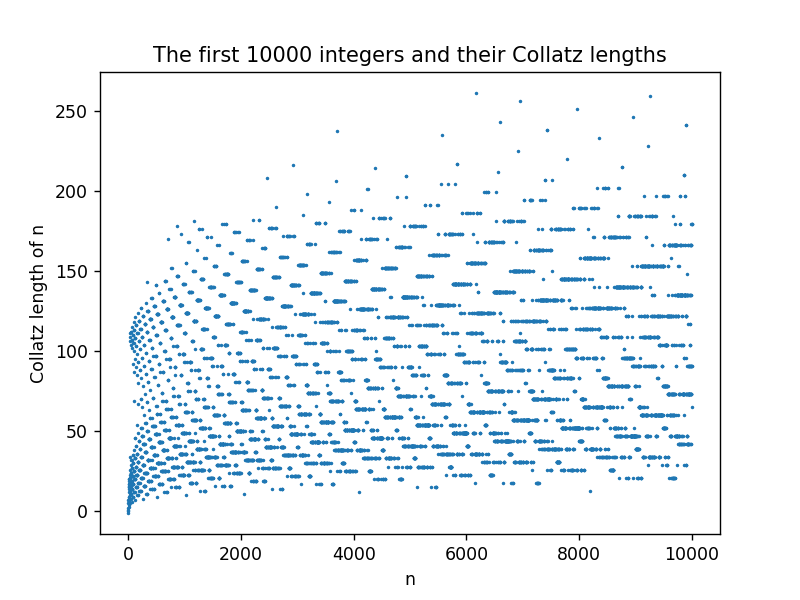

In [5]:
# generate an interactive graph, with hovering to show labels

%matplotlib notebook

numdots = 10000
x=df.n[:numdots]
y=df.length[:numdots]

import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

# x = np.random.rand(15)
# y = np.random.rand(15)
names = np.array([str(_) for _ in y])
c = np.random.randint(1,5,size=numdots)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y, s=1, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))[0]).replace(' ',''), 
                           " ".join([names[n] for n in ind["ind"]][0])).replace(' ','')
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(2)))
#     annot.get_bbox_patch().set_alpha(1)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.title(f'The first {numdots} integers and their Collatz lengths')
plt.xlabel('n')
plt.ylabel('Collatz length of n')
plt.show()

In [6]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(df['n'], df['length'], test_size=0.3, random_state=1)
X_train_reshape = np.array(X_train).reshape(-1,1)

In [7]:
# create dictionaries to hold the models, their predictions, and their accuracies

models = {} # to store the trained models
preds = {} # to store the predictions on the test set
accuracy = {} # to store the model accuracies

In [8]:
# training the models, and assembling the model dictionary

LR_model = LogisticRegression(solver='liblinear', multi_class='ovr')
LR_model.fit(X_train_reshape,y_train)
models['LR']=LR_model

LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train_reshape,y_train)
models['LDA']=LDA_model

KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train_reshape,y_train)
models['KNN']=KNN_model

CART_model = DecisionTreeClassifier()
CART_model.fit(X_train_reshape,y_train)
models['CART']=CART_model

NB_model = GaussianNB()
NB_model.fit(X_train_reshape,y_train)
models['NB']=NB_model

SVM_model = SVC(gamma='auto')
SVM_model.fit(X_train_reshape,y_train)
models['SVM']=SVM_model

Having trained the models, we can now make predictions and calculate accuracies.

In [9]:
# generate predictions, and calculate accuracies of the models

for model in models.keys():
    preds[f'{model}'] = {}
    accuracy[f'{model}'] = {}
    preds[f'{model}']['test'] = models[f'{model}'].predict(np.array(X_test).reshape(-1,1))
    accuracy[f'{model}']['test'] = accuracy_score(y_test,preds[f'{model}']['test'])
    preds[f'{model}']['train'] = models[f'{model}'].predict(np.array(X_train).reshape(-1,1))
    accuracy[f'{model}']['train'] = accuracy_score(y_train,preds[f'{model}']['train'])

In [10]:
# display accuracies

print(f'{"model":<7} {"train_acc":<12} {"test_acc":<8}')
print(f'{"":-<5}   {"":-<9}    {"":-<8}')
for model in models.keys():
    print(f'{model:<7} {round(accuracy[model]["train"],3):<12} {round(accuracy[model]["test"],3):<8}')

model   train_acc    test_acc
-----   ---------    --------
LR      0.016        0.012   
LDA     0.015        0.012   
KNN     0.567        0.333   
CART    1.0          0.398   
NB      0.075        0.061   
SVM     0.963        0.209   


KNN and CART did really well, whereas the others did not do so well. Let's see if visualizations of the predictions alongside the target variable can help us hone in on what's going on with the models.

In [11]:
def sort_coords(xs,ys):
    zipped = zip(xs,ys)
    zipped = sorted(zipped, key = lambda t: t[0])
    return([i for i,j in zipped],[j for i,j in zipped])

In [12]:
def display_plots(mod, length = ''):
    
    x=np.arange(0,10001)
    y1=df.length
    y2=models[f'{mod}'].predict(x.reshape(-1,1))

    if not length: length = len(df.length)

    # plot predicted vs actual on same plot for (1) all generated points, then (2) test set only.
    fig,axes = plt.subplots(1,2)
    fig.set_figheight(8)
    fig.set_figwidth(20)
    fig.suptitle(f'{mod} model - predicted vs actual')

    xs,ys = sort_coords(X_train,y_train)
    axes[0].scatter(x[:length], y1[:length], s=1, c='b', marker="s", label='actual')
    xs,ys = sort_coords(X_train,preds[f'{mod}']['train'])
    axes[0].scatter(x[:length],y2[:length], s=1, c='r', alpha = 0.4,marker="o", label='predicted')
    axes[0].set_title('training set predictions')
    axes[0].legend(loc='upper left');

    temp_list = list(X_test)
    temp_list.sort()
    test_len = -1
    count = 0
    while test_len < 0:
        try:
            length = temp_list.index(length+count)
            break
        except: pass
        count+=1
        if count>len(df):
            length = len(X_test)
            break
    
    xs,ys = sort_coords(X_test,y_test)
    axes[1].scatter(xs[:length], ys[:length], s=1, c='b', marker="s", label='actual')
    xs,ys = sort_coords(X_test,preds[f'{mod}']['test'])
    axes[1].scatter(xs[:length], ys[:length], s=1, c='r', marker="o", label='predicted')
    axes[1].set_title('test set predictions')
    axes[1].legend(loc='upper left');

    plt.show()

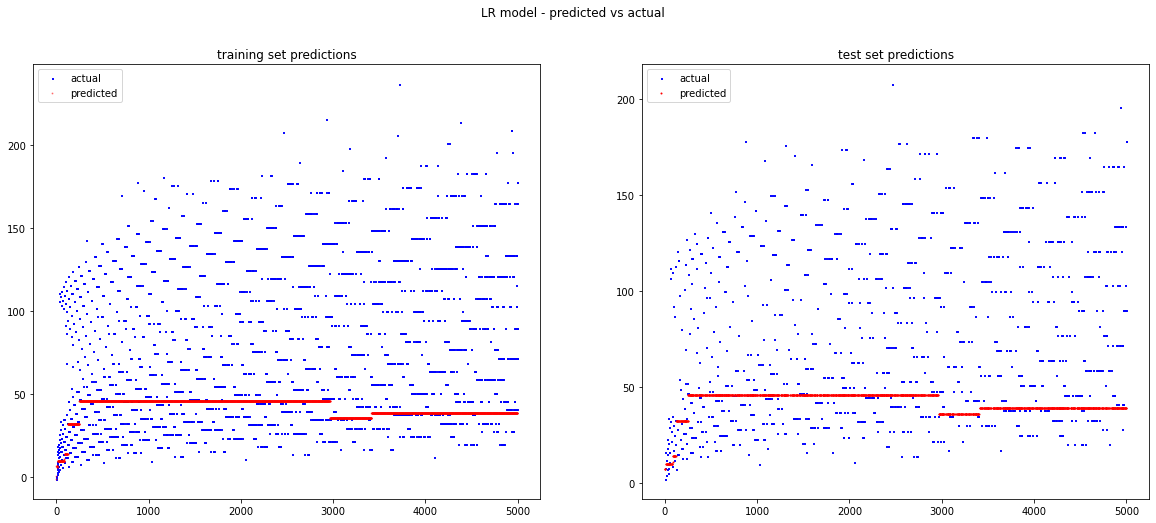

In [13]:
display_plots('LR',5000)

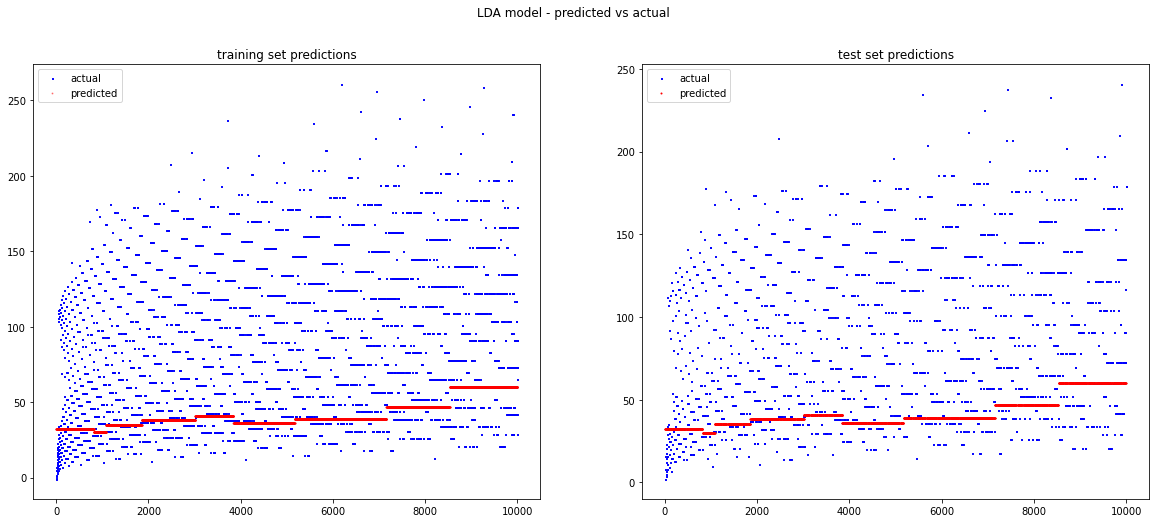

In [14]:
display_plots('LDA')

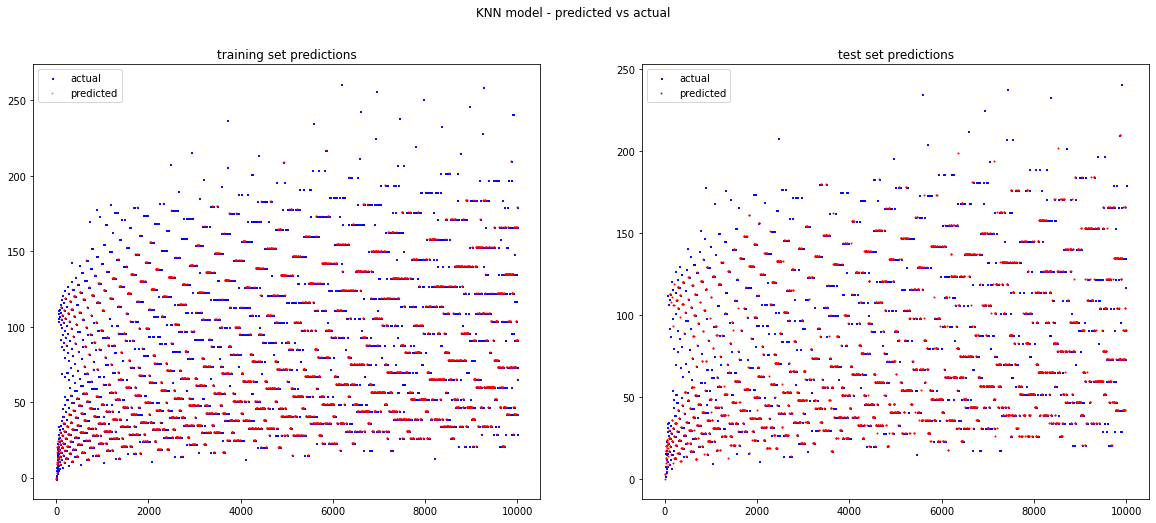

In [15]:
display_plots('KNN')

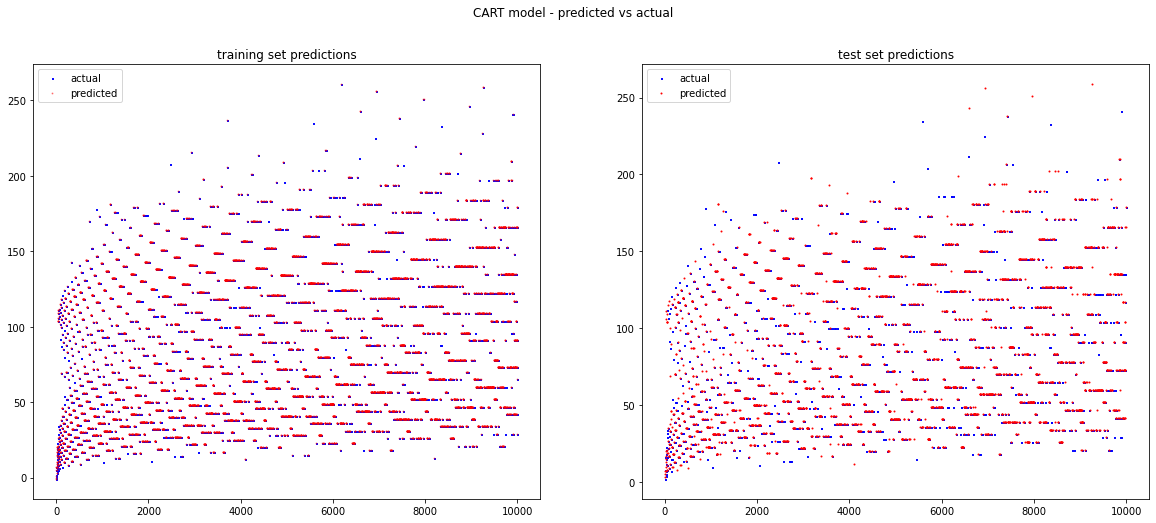

In [16]:
display_plots('CART')

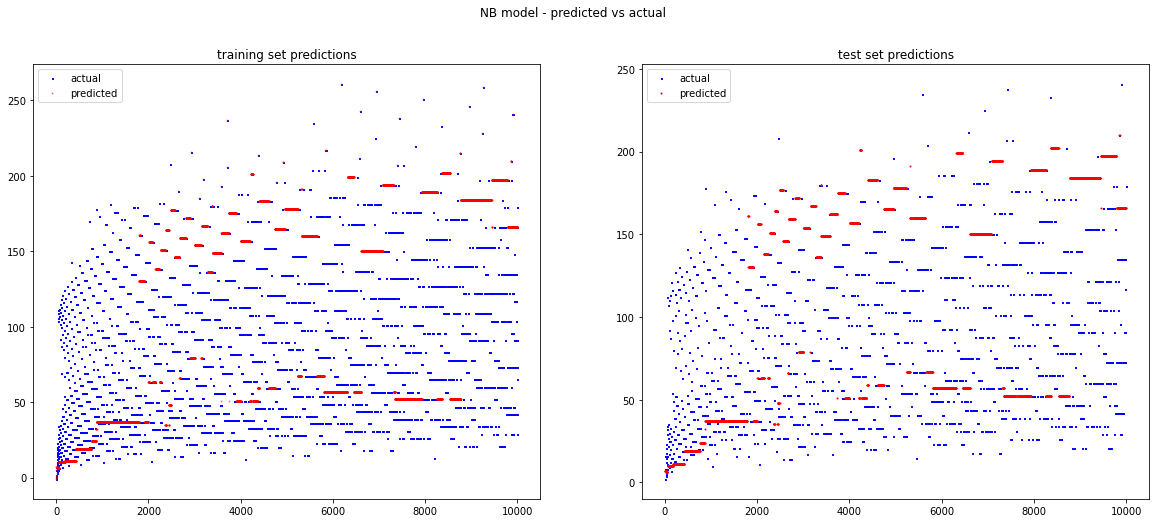

In [17]:
display_plots('NB')

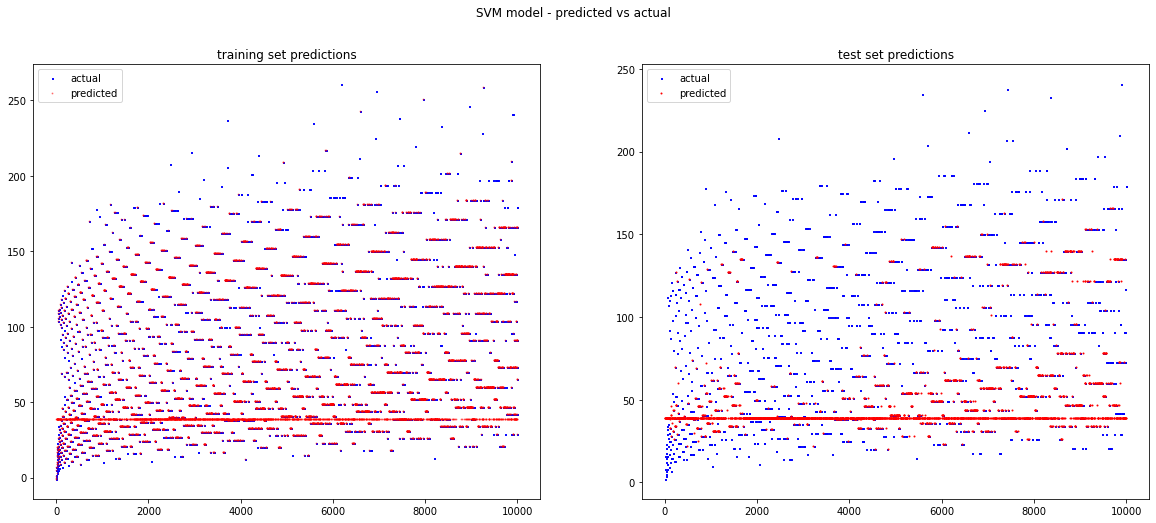

In [18]:
display_plots('SVM')

If we understand the basics of the KNN algorithm, then we can see what KNN is doing by observing that it's good at hitting the long bars but it misses single dots. We might also infer that CART, being a decision tree, is likely making its decisions in a similar way to KNN: using rules about nearby points to say that a point in the test set should have the same length as its neighbors.

Interestingly, CART is also capable of picking up some individual points when we view the graph of the full data set. See, for example, when the input integer is a power of two (hence has Collatz length lower than its immediate neighbors). However, when we view the graph of the CART predictions on just the test set, it appears to fail to pick up these individual points.

The other models are less accurate in general, and we can see the poor matching between their predictions and the actual lengths in these plots.

If our explanation of the success of KNN and CART is correct, then we should expect to see poor generalizations of these models to numbers larger than those in the training set.

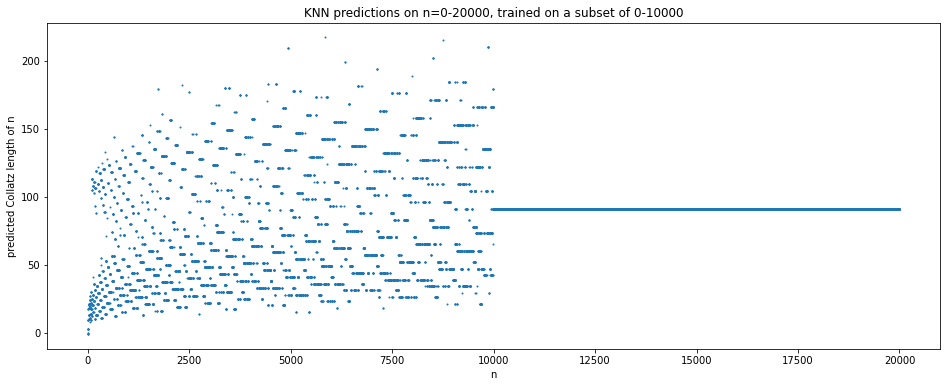

In [19]:
x=np.arange(1,20000)
y=models['KNN'].predict(x.reshape(-1,1))
plt.rcParams["figure.figsize"] = (16,6)
plt.title('KNN predictions on n=0-20000, trained on a subset of 0-10000')
plt.xlabel('n')
plt.ylabel('predicted Collatz length of n')
plt.scatter(x,y,s=1)
plt.show()

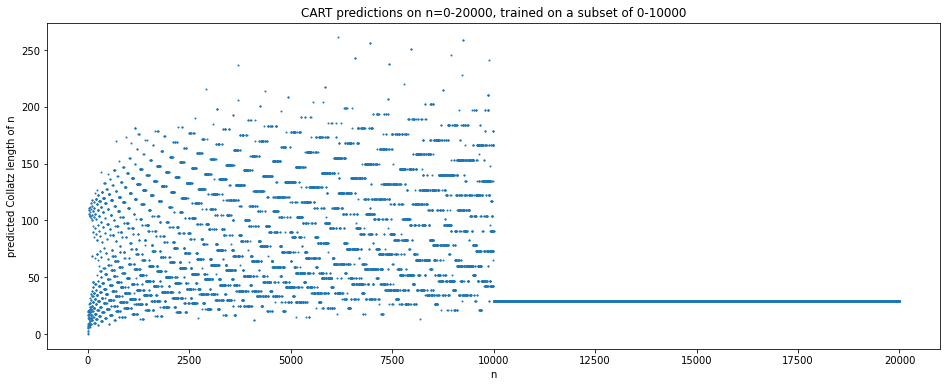

In [20]:
x=np.arange(1,20000)
y=models['CART'].predict(x.reshape(-1,1))
plt.title('CART predictions on n=0-20000, trained on a subset of 0-10000')
plt.xlabel('n')
plt.ylabel('predicted Collatz length of n')
plt.scatter(x,y,s=1)
plt.show()

Indeed, we see that both the CART and KNN models are totally incapable of making reasonable predictions above the numbers in the training data set. This underscores a need when analyzing a data set which is often overlooked: it is sometimes insufficient to break a data set into training and testing chunks, then train on the one and test on the other. Sometimes it is necessary to acquire new data and test the model against the new data. This is especially true, for example, with time series data. The data analyzed here is not a time series, but analogies can be drawn between this data and time series.

In [21]:
''' Check the naive model: just guess the length as the length of the closest number
    in the training set. That's not what the KNN model is doing, right?
'''

# naive model

def naive(num):
    max_num = df.iloc[10000]['length']
    if num>len(df):
        return(max_num)
    train_list = list(X_train)
    count = 0
    while count<len(df):
        try:
            ind = train_list.index(num+count)
            break
        except:
            try:
                ind = train_list.index(num-count)
                break
            except:
                count+=1
        if count>3*len(df):
            print(f'error generating prediction for {num}')
            return
    near_num = train_list[ind]
    return(df.iloc[near_num]['length'])

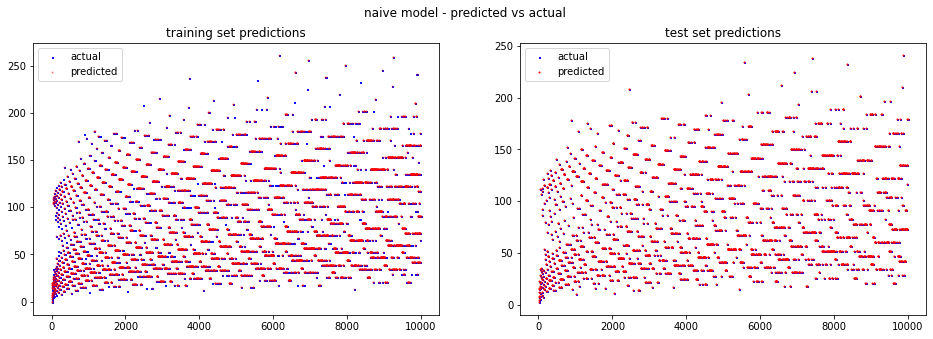

In [22]:
length = 10000

x=np.arange(0,10001)
y1=df.length
y2=[naive(num) for num in x]
    
# plot predicted vs actual on same plot for (1) all generated points, then (2) test set only.
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle(f'naive model - predicted vs actual')

axes[0].scatter(x[:length], y1[:length], s=1, c='b', marker="s", label='actual')
axes[0].scatter(x[:length],y2[:length], s=1, c='r', alpha = 0.4,marker="o", label='predicted')
axes[0].set_title('training set predictions')
axes[0].legend(loc='upper left');

temp_list = list(X_test)
temp_list.sort()
test_len = -1
count = 0
while test_len < 0:
    try:
        length = temp_list.index(length+count)
        break
    except: pass
    count+=1
    if count>len(df):
        length = len(X_test)
        break

xs,ys = sort_coords(X_test,y_test)
axes[1].scatter(xs[:length], ys[:length], s=1, c='b', marker="s", label='actual')
# xs,ys = sort_coords(X_test,[naive(num) for num in X_test])
axes[1].scatter(xs[:length], ys[:length], s=1, c='r', marker="o", label='predicted')
axes[1].set_title('test set predictions')
axes[1].legend(loc='upper left');

plt.show()

In [23]:
# compute accuracy of naive model on training set and test set
naive_acc = {'training':{'right':0,'wrong':0},'test':{'right':0,'wrong':0}}
for num in X_train:
    if naive(num)==df.iloc[num]['length']:
        naive_acc['training']['right']+=1
    else:
        naive_acc['training']['wrong']+=1
for num in X_test:
    if naive(num)==df.iloc[num]['length']:
        naive_acc['test']['right']+=1
    else:
        naive_acc['test']['wrong']+=1

In [24]:
# display accuracy for the naive model
naive_train_acc = naive_acc['training']['right']/(naive_acc['training']['right']+naive_acc['training']['wrong'])
naive_test_acc = naive_acc['test']['right']/(naive_acc['test']['right']+naive_acc['test']['wrong'])


In [25]:
# display accuracies
print(f'{"model":<7} {"train_acc":<12} {"test_acc":<8}')
print(f'{"":-<5}   {"":-<9}    {"":-<8}')
for model in models.keys():
    print(f'{model:<7} {round(accuracy[model]["train"],3):<12} {round(accuracy[model]["test"],3):<8}')
    pass # print a formatted table of model names and accuracies
print(f'{"naive":<7} {round(naive_train_acc,3):<12} {round(naive_test_acc,3):<8}')

model   train_acc    test_acc
-----   ---------    --------
LR      0.016        0.012   
LDA     0.015        0.012   
KNN     0.567        0.333   
CART    1.0          0.398   
NB      0.075        0.061   
SVM     0.963        0.209   
naive   1.0          0.416   


Of course, by its definition, the naive model has 100% accuracy on the training set. It has comparable accuracy on the test set to the more sophisticated machine learning models.

Appendix A.

The sequence of numbers when beginning with 7 is

7 is odd, so we do 3*7+1=22

22 is even, so we do 22/2=11

11 is odd, so we do 3*11+1=34

34 is even, so we do 34/2=17

17 is odd, so we do 3*17+1=52

52 is even, so we do 52/2=26

26 is even, so we do 26/2=13

13 is odd, so we do 3*13+1=40

40 is even, so we do 40/2=20

20 is even, so we do 20/2=10

10 is even, so we do 10/2=5

5 is odd, so we do 3*5+1=16

16 is even, so we do 16/2=8

8 is even, so we do 8/2=4

4 is even, so we do 4/2=2

2 is even, so we do 2/2=1, and we have arrived at 1